**Script Description:** This script loads a pre-processed dataset, prepares the selected features and target variable for predicting SENTEK Soil Moisture Content (SENTEK_SMC).

**File Name:** 02_06_Tunned_XGB_Model.ipynb

**Date:** 2025

**Created by:** Rob Alamgir

##### Import the relevant packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from matplotlib.colors import Normalize
import matplotlib.cm as cm

### Step 1: Load and preprocess the dataset

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
#data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_Updated_V6_Dry.csv"
#data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_Updated_V6_Wet.csv"
complete_dataset = pd.read_csv(data_path)

column_to_remove = 'Porosity'  
complete_dataset = complete_dataset.drop(columns=[column_to_remove])
rename_dict = {"Porosity_BIS4D_SOM": "Porosity","BOFEK_2020_Physical Units": "BOFEK_PU", "Peat_Thickness_2022": "Peat_Thickness"}
complete_dataset.rename(columns=rename_dict, inplace=True)

# Data preprocessing
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'], format='%Y-%m-%d')
complete_dataset['Source_ID'] = complete_dataset['Site_ID'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {complete_dataset.shape}")
filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
filtered_df['BOFEK_PU'] = filtered_df['BOFEK_PU'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

# All selected 10 features
Features = ['Sentinel_1_SMC', 'S1_Backscatter', 'S1_Backscatter_SD', 
            'S2_NDVI', 'S2_NDMI', 'L8_9_LST', 'WLEV_f', 'WTMP_f', 'PET', 'Peat_Thickness']

X = filtered_df[Features]         # Features   
y = filtered_df['SENTEK_SMC']     # Predictor
groups = filtered_df["Source_ID"] # Groups for Leave-One-Group-Out
dates = filtered_df['Date']
print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}, Date: {dates.shape}")

Rows and columns before removing NaNs: (36056, 109)
Rows and columns after removing NaNs: (8368, 109)
Features (X): (8368, 10), Target (y): (8368,), Groups: (8368,), Date: (8368,)


### Step 2: Split the dataset to a training and testing set

In [3]:
# Perform the train-test split with temporal separation
X_train, X_test, y_train, y_test, groups_train, groups_test, dates_train, dates_test = train_test_split(
    X, y, groups, dates,
    test_size=0.3,      # Reserve 30% for the test set
    shuffle=False)      # Ensure temporal order is maintained

#### Perform a couple of checks regarding the data split

In [4]:
# Verify temporal separation
print("\nEarliest date in training set:", dates_train.min())
print("Latest date in training set:", dates_train.max())
print("Earliest date in test set:", dates_test.min())
print("Latest date in test set:", dates_test.max())

# Ensure alignment of training data
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
groups_train = groups_train.loc[X_train.index]
dates_train = dates_train.loc[X_train.index]  # Align dates_train with X_train

# Ensure alignment of test data
X_test, y_test = X_test.align(y_test, join='inner', axis=0)
groups_test = groups_test.loc[X_test.index]
dates_test = dates_test.loc[X_test.index]  # Align dates_test with X_test

# Verify alignment
assert X_train.index.equals(y_train.index) and X_train.index.equals(groups_train.index) and X_train.index.equals(dates_train.index), \
    "Rows in X_train, y_train, groups_train, and dates_train are misaligned!"

assert X_test.index.equals(y_test.index) and X_test.index.equals(groups_test.index) and X_test.index.equals(dates_test.index), \
    "Rows in X_test, y_test, groups_test, and dates_test are misaligned!"

# Print shapes for verification
print("Data shapes after splitting and alignment:")
print(f"Train set: X_train: {X_train.shape}, y_train: {y_train.shape}, groups_train: {groups_train.shape}, dates_train: {dates_train.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}, groups_test: {groups_test.shape}, dates_test: {dates_test.shape}")

# Print group distribution in train and test sets
print("Group distribution in training set:")
print(groups_train.value_counts())
print("\nGroup distribution in test set:")
print(groups_test.value_counts())

# Calculate and print the number of unique groups in train and test sets
unique_groups_train = groups_train.nunique()
unique_groups_test = groups_test.nunique()
print(f"\nUnique groups in train: {unique_groups_train}, in test: {unique_groups_test}")


Earliest date in training set: 2021-09-01 00:00:00
Latest date in training set: 2023-05-15 00:00:00
Earliest date in test set: 2023-05-15 00:00:00
Latest date in test set: 2024-05-13 00:00:00
Data shapes after splitting and alignment:
Train set: X_train: (5857, 10), y_train: (5857,), groups_train: (5857,), dates_train: (5857,)
Test set: X_test: (2511, 10), y_test: (2511,), groups_test: (2511,), dates_test: (2511,)
Group distribution in training set:
Source_ID
7     622
11    621
16    621
12    620
17    617
4     594
8     592
3     560
2     514
1     496
Name: count, dtype: int64

Group distribution in test set:
Source_ID
12    365
1     364
11    352
17    343
2     284
16    256
4     184
7     182
8     181
Name: count, dtype: int64

Unique groups in train: 10, in test: 9


In [5]:
# Apply StandardScaler to numerical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

### Step 3: Define and fit the tuned BRT model

In [6]:
model = XGBRegressor(n_estimators=800,
                     max_depth=5,
                     learning_rate=0.01,
                     subsample=0.8,
                     colsample_bytree=0.5,
                     random_state=42, 
                     enable_categorical=True)

model.fit(X_train_scaled, y_train, 
          eval_set=[(X_test_scaled, y_test)],
          verbose=50)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
bias = np.mean(y_pred - y_test)
ubrmse = np.sqrt(np.mean((y_pred - y_test - bias) ** 2))

print(f"\nModel Performance on Test Set:")
print(f"Coefficient of Determination (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Bias (Mean Bias Error): {bias:.4f}")
print(f"Unbiased Root Mean Squared Error (ubRMSE): {ubrmse:.4f}")

[0]	validation_0-rmse:0.15716
[50]	validation_0-rmse:0.12556
[100]	validation_0-rmse:0.10853
[150]	validation_0-rmse:0.09809
[200]	validation_0-rmse:0.09254
[250]	validation_0-rmse:0.08943
[300]	validation_0-rmse:0.08806
[350]	validation_0-rmse:0.08738
[400]	validation_0-rmse:0.08748
[450]	validation_0-rmse:0.08774
[500]	validation_0-rmse:0.08814
[550]	validation_0-rmse:0.08861
[600]	validation_0-rmse:0.08896
[650]	validation_0-rmse:0.08920
[700]	validation_0-rmse:0.08955
[750]	validation_0-rmse:0.08982
[799]	validation_0-rmse:0.09045

Model Performance on Test Set:
Coefficient of Determination (R²): 0.6677
Mean Squared Error (MSE): 0.0082
Mean Absolute Error (MAE): 0.0649
Root Mean Squared Error (RMSE): 0.0904
Bias (Mean Bias Error): -0.0220
Unbiased Root Mean Squared Error (ubRMSE): 0.0877


### Step 4: Evaluate the performace of the test set

In [7]:
# Create Dataframe with the actual & predicted values along with other columns    
plotting_df = pd.DataFrame({'Source_ID': groups_test,'Date': dates_test,'Actual_SENTEK_SMC': y_test,'Predicted_SENTEK_SMC': y_pred})    
source_column = complete_dataset[['Site_ID','DOY']]
merged_df = plotting_df.merge(source_column, left_index=True, right_index=True, how='left')
merged_df['Source_ID'] = merged_df['Source_ID'].astype('category')

#### Plot Actual vs Predicted plot and residual plot 

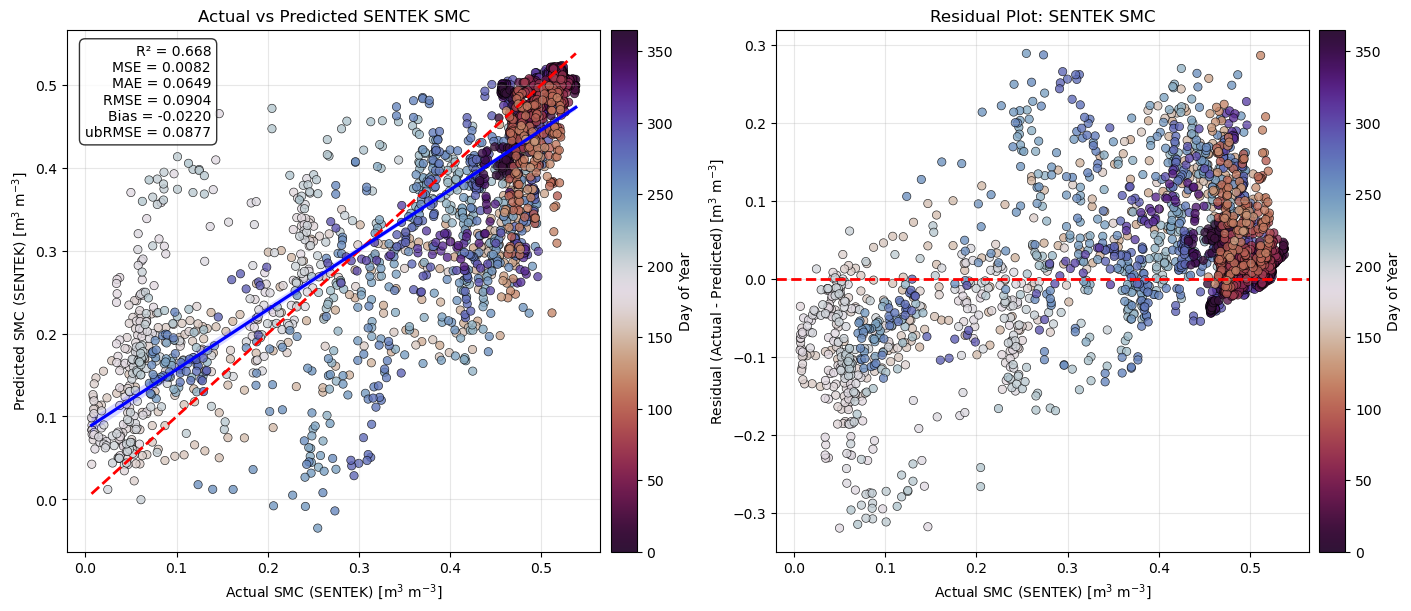

In [8]:
merged_df['Residual'] = merged_df['Actual_SENTEK_SMC'] - merged_df['Predicted_SENTEK_SMC']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

cmap = plt.get_cmap('twilight_shifted_r')  # Use cyclic colormap
norm = Normalize(vmin=0, vmax=365)

sns.scatterplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC',
                hue='DOY', palette=cmap, hue_norm=norm, edgecolor='k', alpha=0.8, ax=axes[0], legend=False)
x_vals = np.linspace(merged_df['Actual_SENTEK_SMC'].min(), merged_df['Actual_SENTEK_SMC'].max(), 100)
axes[0].plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2, label="1:1 Line")

sns.regplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC',
            scatter=False, color='blue', ax=axes[0], line_kws={'label': "Regression Line"})
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[0], pad=0.02)
cbar1.set_label('Day of Year')
axes[0].set_xlabel("Actual SMC (SENTEK) [m$^{3}$ m$^{-3}$]")
axes[0].set_ylabel("Predicted SMC (SENTEK) [m$^{3}$ m$^{-3}$]")
axes[0].set_title("Actual vs Predicted SENTEK SMC")
axes[0].grid(alpha=0.3)

metrics_text = (
    f"R² = {r2:.3f}\n"
    f"MSE = {mse:.4f}\n"
    f"MAE = {mae:.4f}\n"
    f"RMSE = {rmse:.4f}\n"
    f"Bias = {bias:.4f}\n"
    f"ubRMSE = {ubrmse:.4f}"
)
axes[0].text(0.27, 0.79, metrics_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

sns.scatterplot(data=merged_df, x='Actual_SENTEK_SMC', y='Residual', 
                hue='DOY', palette=cmap, hue_norm=norm, edgecolor='k', alpha=0.8, ax=axes[1], legend=False)

axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[1], pad=0.02)
cbar2.set_label('Day of Year')
axes[1].set_xlabel("Actual SMC (SENTEK) [m$^{3}$ m$^{-3}$]")
axes[1].set_ylabel("Residual (Actual - Predicted) [m$^{3}$ m$^{-3}$]")
axes[1].set_title("Residual Plot: SENTEK SMC")
axes[1].grid(alpha=0.3)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Final_Model_DOY_plot.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

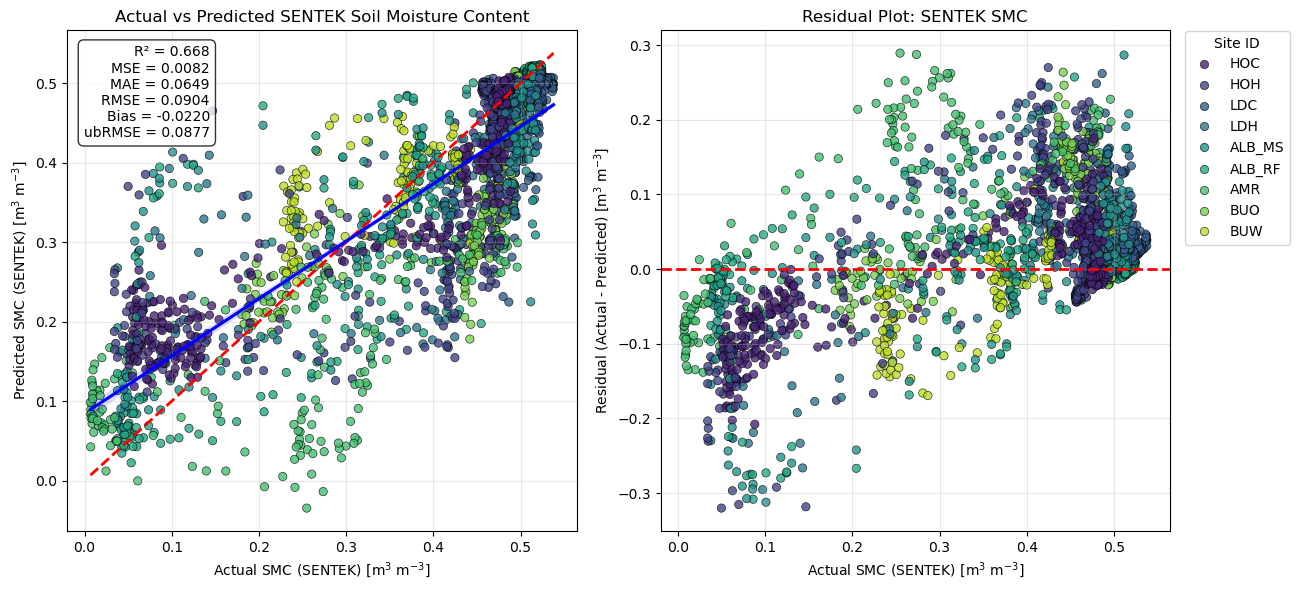

In [10]:
merged_df['Residual'] = merged_df['Actual_SENTEK_SMC'] - merged_df['Predicted_SENTEK_SMC']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[0], legend=False)
x_vals = np.linspace(merged_df['Actual_SENTEK_SMC'].min(), merged_df['Actual_SENTEK_SMC'].max(), 100)
axes[0].plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2, label="1:1 Line")

sns.regplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC',
            scatter=False, color='blue', ax=axes[0], line_kws={'label': "Regression Line"})

axes[0].set_title('Actual vs Predicted SENTEK Soil Moisture Content')
axes[0].set_xlabel('Actual SMC (SENTEK) [m$^{3}$ m$^{-3}$]')
axes[0].set_ylabel('Predicted SMC (SENTEK) [m$^{3}$ m$^{-3}$]')
axes[0].grid(alpha=0.3)

metrics_text = (
    f"R² = {r2:.3f}\n"
    f"MSE = {mse:.4f}\n"
    f"MAE = {mae:.4f}\n"
    f"RMSE = {rmse:.4f}\n"
    f"Bias = {bias:.4f}\n"
    f"ubRMSE = {ubrmse:.4f}"
)
axes[0].text(0.28, 0.78, metrics_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

sns.scatterplot(data=merged_df, x='Actual_SENTEK_SMC', y='Residual',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[1], legend=False)

axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residual Plot: SENTEK SMC')
axes[1].set_xlabel('Actual SMC (SENTEK) [m$^{3}$ m$^{-3}$]')
axes[1].set_ylabel('Residual (Actual - Predicted) [m$^{3}$ m$^{-3}$]')
axes[1].grid(alpha=0.3)

fig_legend = plt.figure()
legend_ax = fig_legend.add_subplot(111)
legend_plot = sns.scatterplot(
    data=merged_df, x='Actual_SENTEK_SMC', y='Residual',
    hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=legend_ax)
handles, labels = legend_ax.get_legend_handles_labels()
plt.close(fig_legend)

fig.legend(handles=handles, labels=labels, title='Site ID',
           bbox_to_anchor=(0.85, 0.94), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Final_Model_AOI_plot.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

In [ ]:
plot_data = pd.DataFrame({'Date': dates_test,'Actual': y_test,'Predicted': y_pred})   
plot_data = plot_data.sort_values(by='Date')                                         
plt.figure(figsize=(12,6))
sns.scatterplot(data=plot_data, x='Date', y='Actual', label='Actual', color='blue', alpha=0.7)
sns.scatterplot(data=plot_data, x='Date', y='Predicted', label='Predicted', color='red', alpha=0.7)

# Add grid and formatting
plt.title('Actual vs Predicted Scatter Plot Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('SWCT_1_015', fontsize=12)  
plt.legend(fontsize=12)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.6)  

plt.tight_layout()
plt.show()